In [1]:
import os
import pandas as pd
import numpy as np
import json
import subprocess
from Bio import SeqIO
import plotnine
import dask
from dask import delayed
from dask.distributed import Client
from itertools import combinations
import difflib
import scipy
import random
import pysais
from difflib import SequenceMatcher
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import ahocorasick
from ahocorasick import Automaton
import sys

### Functions to use

In [15]:
def lenset(input_list):
    return len(set(input_list))

def polish_input_frame(input_dir,cluster_threshold,kmer_no,sample_id,sample_code,filename="placeholder",
                       old_dir=False,
                       new_dir=True):
    if old_dir:
        curr_concat_read_in=pd.read_csv(os.path.join(input_dir,sample_id+"_kmerlen_"+str(kmer_no)+\
                                    "_dist_"+str(cluster_threshold)+"progress."+str(sample_code)+".csv"))
    elif new_dir:
        curr_concat_read_in=pd.read_csv(os.path.join(input_dir,filename))
    else:
        curr_concat_read_in=pd.read_csv(os.path.join(input_dir,sample_id+"_kmerlen_"+str(kmer_no)+\
                                    "_dist_"+str(cluster_threshold)+"_"+str(sample_code)+".progress.csv"))

    curr_concat_read_in["sample_code"] = [1 if sample_id in curr else 0 for curr in \
                                  list(curr_concat_read_in.Source_ID)]
    tester_curr=curr_concat_read_in.groupby(["cluster_blob","HomClust"])[["Division","Domain","Family",
                                                                          "Class","sample_code"]].\
        agg([set,lenset,len,sum]).reset_index()
    tester_curr.columns = tester_curr.columns.map('|'.join).str.strip('|')
    
    merged_w_eukulele=merged_eukulele.merge(curr_concat_read_in.\
                                  rename({"Source_ID":"Revised_name"},
                                         axis="columns")[["Revised_name","HomClust",
                                                          "cluster_blob"]].\
                                            merge(tester_curr),
                left_on="Revised_name",right_on="Revised_name",how="outer")
    
    return curr_concat_read_in,tester_curr,merged_w_eukulele

def build_upset_df(tester_curr,cluster_threshold):
    
    to_check=tester_curr.loc[[(("Rhizosoleniaceae" in curr)|("Skeletonemataceae" in curr)|\
                              ("Thalassiosiraceae" in curr)|("Hemiaulaceae" in curr))&\
                             (np.nan in curr) for curr in tester_curr["Family|set"]]]

    all_set=set()
    #for curr in to_check["Family|set"]:
    #    all_set.update(curr)
    #all_list_set = list(all_set)
    all_list_set = list(set(["Rhizosoleniaceae","Hemiaulaceae","Skeletonemataceae",
                    "Thalassiosiraceae"])) #+ list(set(tax_table.loc[tax_table.Class=="Bacillariophyta","Family"]))))#[curr.strip() for curr in list(all_set)]

    all_ochrophyte=list(set(tax_table.loc[tax_table.Division=="Ochrophyta","Family"]))
    build_upset_df = pd.DataFrame()
    counter = 0
    for curr in range(len(to_check.index)):
        curr_df = pd.DataFrame()
        for curr_tax in all_list_set:
            curr_tax_label=curr_tax
            if curr_tax != curr_tax:
                curr_tax_label = "Sample_NB"
            if curr_tax in to_check.iloc[curr].loc["Family|set"]:
                curr_df[curr_tax_label] = [True]
            else:
                curr_df[curr_tax_label] = [False]
        curr_df["number_seqs"] = to_check.iloc[curr].loc["sample_code|sum"]
        if len(to_check.iloc[curr].loc["Family|set"].difference(all_list_set)) > 1:
            curr_df["non-diatom"] = [True]
        else:
            curr_df["non-diatom"] = [False]

        if len(to_check.iloc[curr].loc["Family|set"].difference(all_ochrophyte)) > 1:
            curr_df["non-ochrophyte"] = [True]
        else:
            curr_df["non-ochrophyte"] = [False]

        if len(to_check.iloc[curr].loc["Domain|set"].difference(set(["Eukaryota",np.nan]))) > 0:
            curr_df["non-eukaryote"] = [True]
        else:
            curr_df["non-eukaryote"] = [False]
        build_upset_df = pd.concat([build_upset_df,curr_df])
        #if counter > 100:
        #    break
        counter=counter+1
    non_target_diatom=list(set(tax_table.loc[tax_table.Class=="Bacillariophyta","Family"])-
     set(["Rhizosoleniaceae","Hemiaulaceae","Skeletonemataceae","Thalassiosiraceae",
          "Stephanodiscaceae","Chaetocerotales"]))
    build_upset_df["other_diatom"]=build_upset_df[non_target_diatom].any(axis=1)

    build_upset_df = build_upset_df.loc[:,~build_upset_df.columns.duplicated()].copy().\
        groupby(["Rhizosoleniaceae","Hemiaulaceae","Skeletonemataceae",
                 "Thalassiosiraceae","Stephanodiscaceae","Chaetocerotales"]+\
                ["non-diatom","non-eukaryote","non-ochrophyte","other_diatom"])\
        ["number_seqs"].sum()
    
    build_upset_df["Dist"] = cluster_threshold
    return build_upset_df
                            
def aggset(input_set):
    if input_set!=input_set:
        return "NoDeepClustWDiatom"
    return("_".join(sorted(list(set([str(curr) for curr in input_set if curr==curr])))))
                            
def returnagg(merged_eukulele):
    merged_eukulele["Family|agg"] = [aggset(curr) for curr in merged_eukulele["Family|set"]]
    merged_eukulele["Division|agg"] = [aggset(curr) for curr in merged_eukulele["Division|set"]]

    return merged_eukulele[["Family|agg","Family|lenset","Division","Domain","Family","Family|set",
                          "Division|set","Class|set","transcript_name"]]

tax_table=pd.read_csv("/vortexfs1/omics/alexander/data/databases/marmmetsp-5Dec2022/tax-table.txt",sep="\t")
diatom_families=list(set(tax_table.loc[tax_table.Class.isin(["Bacillariophyta"]),"Family"]))
ochrophyte_families=list(set(tax_table.loc[tax_table.Division.isin(["Ochrophyta"]),"Family"]))

def check_in_diatoms(list_families,fam_question):
    if not fam_question in list_families:
        return False
    for curr_family in list_families:
        if not curr_family in diatom_families:
            return False
        
    return True

def check_in_ochrophyta(list_families,fam_question):
    if not fam_question in list_families:
        return False
    for curr_family in list_families:
        if not curr_family in ochrophyte_families:
            return False
        
    return True

### EUKulele read-in

In [3]:
EUKulele_MAD_cds_marmmetsp=pd.read_csv("/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic-eLife/snakemake-workflows/eukulele-snake/EUKulele_marmmetsp_NB_MAD_cds_better_diatom/taxonomy_estimation/MAD.fasta.transdecoder-estimated-taxonomy.out",
                                            sep="\t")

import time
import itertools
original_fasta = "/vortexfs1/omics/alexander/akrinos/2021-testing-eukrhythmic/eukrhythmic_paper_narragansett/intermediate-files/04-compare/13-MAD-proteins/MAD.fasta.transdecoder.pep"
behaved_fasta = "nb_fasta_file.fasta"
os.system(" ".join(["bash","/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/remove_newlines.sh",original_fasta,">",behaved_fasta]))

counter=1
start_time=time.time()
sequence_dict=dict()
with open(behaved_fasta,"r") as f:
    counter=1
    for line1,line2 in itertools.zip_longest(*[f]*2):
        sequence_dict[line1.split(">")[1].split(" ")[0]]=line2
        #if counter > 2000000:
        #    break
        counter=counter+1
    print(time.time()-start_time)
    
all_sequences_nb=pd.DataFrame({"transcript_name":list(sequence_dict.keys())})

merged_eukulele=EUKulele_MAD_cds_marmmetsp.merge(all_sequences_nb,how="outer")
merged_eukulele[["Domain","Division","Phylum","Class","Order",
       "Family","Genus","Species"]] = merged_eukulele.full_classification.str.split(pat="; ",n=8,expand=True)

merged_eukulele["Revised_name"] = [str(curr).replace(".","N") for curr in merged_eukulele["transcript_name"]]

14.427835464477539


In [4]:
tax_table=pd.read_csv("/vortexfs1/omics/alexander/data/databases/marmmetsp-5Dec2022/tax-table.txt",sep="\t")
diatom_mmetsps=list(tax_table.loc[tax_table.Family.isin(["Skeletonemataceae","Rhizosoleniaceae",
                                     "Hemiaulaceae","Thalassiosiraceae"]),"Source_ID"])

### Read in tax-aliquots file

In [5]:
curr_concat_read_in0_5,tester_curr0_5_kmer_5,curr_concat_read_in0_5=polish_input_frame(input_dir="/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/tax-aliquots/final_and_complete_files",
                                                                              filename="NarBay_0.5_AllDiatoms.csv",
                                                                              cluster_threshold=0.5,
                                                                              kmer_no=5,sample_id="NarBay",sample_code="diatomsall2")

In [8]:
%%time
curr_concat_read_in0_5,tester_curr0_5_kmer_5,merged_w_eukulele0_5_kmer_5=polish_input_frame(input_dir="/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/tax-aliquots/final_and_complete_files",
                                                                              filename="NarBay_0.5_AllDiatoms.csv",
                                                                              cluster_threshold=0.5,
                                                                              kmer_no=5,sample_id="NarBay",sample_code="diatomsall2")

CPU times: user 12min 36s, sys: 37.6 s, total: 13min 14s
Wall time: 13min 16s


In [72]:
%%time
curr_concat_read_in0_5_kmer_3,tester_curr0_5_kmer_3,merged_w_eukulele0_5_kmer_3=polish_input_frame(input_dir="/vortexfs1/omics/alexander/akrinos/2022-euk-diversity/code/tax-aliquots",
                                                                              filename="NarBay_kmerlen_3_dist_0.5_diatomsall2.progress.csv",
                                                                              cluster_threshold=0.5,
                                                                              kmer_no=3,sample_id="NarBay",sample_code="diatomsall2")

CPU times: user 12min 11s, sys: 31 s, total: 12min 42s
Wall time: 12min 44s


In [11]:
merged_w_eukulele0_5_agg=returnagg(merged_w_eukulele0_5_kmer_5)
merged_w_eukulele0_5_agg["Family"] = ["Unclassified" if (curr!=curr)|(curr is None) else curr for \
                                      curr in merged_w_eukulele0_5_agg["Family"]]
merged_w_eukulele0_5_agg.groupby(["Family","Family|agg"]).transcript_name.count().reset_index().\
    sort_values("transcript_name",ascending=False).head(n=30)

<ipython-input-11-0b6b98b39a67>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Family,Family|agg,transcript_name
84104,Unclassified,NoDeepClustWDiatom,2778828
62443,Unclassified,,1326933
44362,Prorocentraceae,NoDeepClustWDiatom,487004
50322,Skeletonemataceae,Skeletonemataceae,260196
44423,Prorocentraceae,Prorocentraceae,109141
56095,Suessiaceae,NoDeepClustWDiatom,92756
53246,Suessiaceae,,71033
48543,Skeletonemataceae,,67291
25451,Hemiaulaceae,,62516
39127,Pelagomonadaceae,NoDeepClustWDiatom,56143


In [13]:
merged_cts=merged_w_eukulele0_5_agg.groupby(["Family","Family|agg"]).transcript_name.count().reset_index().\
    sort_values("transcript_name",ascending=False)
merged_cts=merged_cts.loc[merged_cts.transcript_name>0]
merged_cts.loc[(merged_cts.Family=="Skeletonemataceae")|\
               (["Skeletonema" in curr for curr in merged_cts["Family|agg"]])].head(n=40)

,Family,Family|agg,transcript_name
50322,Skeletonemataceae,Skeletonemataceae,260196
48543,Skeletonemataceae,,67291
50342,Skeletonemataceae,Skeletonemataceae_Thalassiosiraceae,37483
50332,Skeletonemataceae,Skeletonemataceae_Stephanodiscaceae_Thalassios...,14529
59133,Thalassiosiraceae,Skeletonemataceae_Thalassiosiraceae,9271
50266,Skeletonemataceae,NoDeepClustWDiatom,8981
50365,Skeletonemataceae,Thalassiosiraceae,5191
59126,Thalassiosiraceae,Skeletonemataceae_Stephanodiscaceae_Thalassios...,3885
52026,Stephanodiscaceae,Skeletonemataceae_Stephanodiscaceae_Thalassios...,3110
85503,Unclassified,Skeletonemataceae,2543


In [70]:
merged_cts.groupby(["Family"]).transcript_name.sum().reset_index().sort_values("transcript_name")

,Family,transcript_name
77,Desulfurellaceae,1
79,Desulfuromonadaceae,1
269,Thermoplasmataceae,1
221,Pseudonocardiaceae,1
268,Thermodesulfobacteriaceae,1
...,...,...
45,Chrysochromulinaceae,137799
258,Suessiaceae,232730
242,Skeletonemataceae,431670
213,Prorocentraceae,677088


In [71]:
merged_cts.loc[merged_cts.Family=="Unclassified"].groupby(["Family|agg"]).transcript_name.sum().reset_index().sort_values("transcript_name")

,Family|agg,transcript_name
5258,Discosea_XXX_Euplotidae_Filamoebidae_Paramoebidae,1
5059,Dictyochales_Pinguiochrysidaceae_Vaucheriaceae,1
2286,Bolidomonadaceae_Chaetocerotales_Cymatosiracea...,1
2287,Bolidomonadaceae_Chaetocerotales_Cymatosiracea...,1
2288,Bolidomonadaceae_Chaetocerotales_Euplotidae_Rh...,1
...,...,...
123,Amphidomataceae_Amphipleuraceae_Aulacoseiracea...,1956
6651,Skeletonemataceae,2543
6085,Hemiaulaceae,5000
0,,1326933


In [47]:
merged_cts["Number_Reps"] = [curr.count("_") for curr in merged_cts["Family|agg"]]

In [57]:
merged_cts.loc[merged_cts.Family!="Unclassified"].transcript_name.sum()

3419322

In [67]:
merged_cts.loc[(merged_cts.Family=="Unclassified")&(merged_cts["Family|agg"]!="NoDeepClustWDiatom")&\
               (merged_cts["Family|agg"]!='')&
               (merged_cts.Number_Reps<5)].transcript_name.sum()

43651

In [58]:
43651/3419322

0.012765981092158036

In [29]:
fam_question="Rhizosoleniaceae"
rhizosoleniaceae_subframe = merged_cts.loc[(merged_cts.Family==fam_question)|\
               ([fam_question in curr for curr in merged_cts["Family|agg"]])]
rhizosoleniaceae_subframe["AnnotationType"] = ["BLAST LCA, tax-aliquots coherent" if (fam_curr==fam_question) & \
                                               (fam_question==fam_agg)\
                                               else "BLAST LCA, tax-aliquots mixed" if (fam_curr==fam_question)&\
                                               (fam_question in fam_agg)  else \
                                                "BLAST LCA, tax-aliquots disagrees" if \
                                               (fam_curr==fam_question) & (fam_agg != "") & (fam_agg != "NoDeepClustWDiatom") \
                                                else "BLAST LCA" if \
                                               (fam_curr==fam_question)\
                                               else "tax-aliquots coherent" if (fam_question==fam_agg)\
                                               else "tax-aliquots diatom" if check_in_diatoms(fam_agg.split("_"),fam_question)\
                                               else "tax-aliquots ochrophyte" if check_in_ochrophyta(fam_agg.split("_"),fam_question)\
                                               else "tax-aliquots" for fam_agg,fam_curr in \
                                               zip(rhizosoleniaceae_subframe["Family|agg"],
                                                   rhizosoleniaceae_subframe["Family"])]

<ipython-input-29-0756b076ca32>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
fam_question="Hemiaulaceae"
Hemiaulaceae_subframe = merged_cts.loc[(merged_cts.Family==fam_question)|\
               ([fam_question in curr for curr in merged_cts["Family|agg"]])]
Hemiaulaceae_subframe["AnnotationType"] = ["BLAST LCA, tax-aliquots coherent" if (fam_curr==fam_question) & \
                                               (fam_question==fam_agg)\
                                               else "BLAST LCA, tax-aliquots mixed" if (fam_curr==fam_question)&\
                                               (fam_question in fam_agg)  else \
                                                "BLAST LCA, tax-aliquots disagrees" if \
                                               (fam_curr==fam_question) & (fam_agg != "") & (fam_agg != "NoDeepClustWDiatom") \
                                                else "BLAST LCA" if \
                                               (fam_curr==fam_question)\
                                               else "tax-aliquots coherent" if (fam_question==fam_agg)\
                                               else "tax-aliquots diatom" if check_in_diatoms(fam_agg.split("_"),fam_question)\
                                               else "tax-aliquots ochrophyte" if check_in_ochrophyta(fam_agg.split("_"),fam_question)\
                                               else "tax-aliquots" for fam_agg,fam_curr in \
                                               zip(Hemiaulaceae_subframe["Family|agg"],
                                                   Hemiaulaceae_subframe["Family"])]

<ipython-input-28-043e992fcc54>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [24]:
merged_cts

,Family,Family|agg,transcript_name
84104,Unclassified,NoDeepClustWDiatom,2778828
62443,Unclassified,,1326933
44362,Prorocentraceae,NoDeepClustWDiatom,487004
50322,Skeletonemataceae,Skeletonemataceae,260196
44423,Prorocentraceae,Prorocentraceae,109141
...,...,...,...
45996,Pycnococcaceae,Bathycoccaceae_Chloropicaceae_Crustomastigacea...,1
44994,Prymnesiaceae,Bicoecaceae,1
16340,Dinobryaceae,Goniodomataceae_Kareniaceae_Peridiniaceae_Peri...,1
31802,Kryptoperidiniaceae,Moraxellaceae,1


In [25]:
fam_question="Skeletonemataceae"
Skeletonemataceae_subframe = merged_cts.loc[(merged_cts.Family==fam_question)|\
               ([fam_question in curr for curr in merged_cts["Family|agg"]])]
Skeletonemataceae_subframe["AnnotationType"] = ["BLAST LCA, tax-aliquots coherent" if (fam_curr==fam_question) & \
                                               (fam_question==fam_agg)\
                                               else "BLAST LCA, tax-aliquots mixed" if (fam_curr==fam_question)&\
                                               (fam_question in fam_agg) else \
                                                "BLAST LCA, tax-aliquots disagrees" if \
                                               (fam_curr==fam_question) & (fam_agg != "") & (fam_agg != "NoDeepClustWDiatom") \
                                                else "BLAST LCA" if \
                                               (fam_curr==fam_question)\
                                               else "tax-aliquots coherent" if (fam_question==fam_agg)\
                                               else "tax-aliquots diatom" if check_in_diatoms(fam_agg.split("_"),fam_question)\
                                               else "tax-aliquots ochrophyte" if check_in_ochrophyta(fam_agg.split("_"),fam_question)\
                                               else "tax-aliquots" for fam_agg,fam_curr in \
                                               zip(Skeletonemataceae_subframe["Family|agg"],
                                                   Skeletonemataceae_subframe["Family"])]

<ipython-input-25-18e7d8b79b45>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [27]:
Skeletonemataceae_subframe.loc[Skeletonemataceae_subframe["AnnotationType"] == \
                               "BLAST LCA, tax-aliquots disagrees"]

,Family,Family|agg,transcript_name,AnnotationType
50365,Skeletonemataceae,Thalassiosiraceae,5191,"BLAST LCA, tax-aliquots disagrees"
50351,Skeletonemataceae,Stephanodiscaceae_Thalassiosiraceae,356,"BLAST LCA, tax-aliquots disagrees"
49553,Skeletonemataceae,Chaetocerotales,171,"BLAST LCA, tax-aliquots disagrees"
50350,Skeletonemataceae,Stephanodiscaceae,141,"BLAST LCA, tax-aliquots disagrees"
50257,Skeletonemataceae,Lithodesmiaceae_Thalassiosiraceae,108,"BLAST LCA, tax-aliquots disagrees"
...,...,...,...,...
48958,Skeletonemataceae,Amphipleuraceae_Cyclophoraceae_Fragilariaceae_...,1,"BLAST LCA, tax-aliquots disagrees"
48967,Skeletonemataceae,Amphipleuraceae_Entomoneidaceae_Fragilariaceae...,1,"BLAST LCA, tax-aliquots disagrees"
48971,Skeletonemataceae,Amphipleuraceae_Fragilariaceae_Rhizosoleniaceae,1,"BLAST LCA, tax-aliquots disagrees"
48767,Skeletonemataceae,Amphipleuraceae_Bacillariaceae_Catenulaceae_Ch...,1,"BLAST LCA, tax-aliquots disagrees"


/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 6.4 x 4.8 in image.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: diatom_tax_aliquots.pdf
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:370: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.
/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/facets/facet.py:549: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


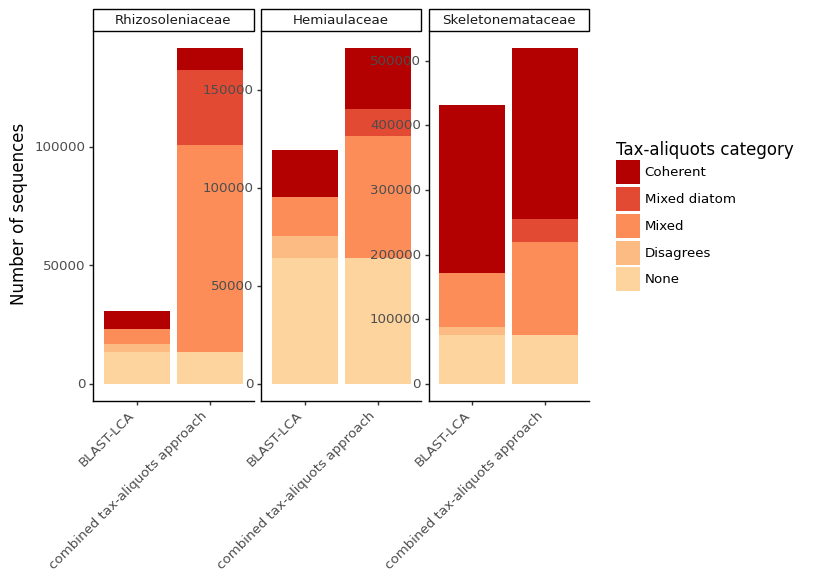

<ggplot: (2932966325125)>

In [46]:
skel_group=Skeletonemataceae_subframe.groupby(["AnnotationType"]).transcript_name.sum().reset_index()
skel_group["Family"]="Skeletonemataceae"
rhizo_group=rhizosoleniaceae_subframe.groupby(["AnnotationType"]).transcript_name.sum().reset_index()
rhizo_group["Family"]="Rhizosoleniaceae"
hemi_group=Hemiaulaceae_subframe.groupby(["AnnotationType"]).transcript_name.sum().reset_index()
hemi_group["Family"]="Hemiaulaceae"
concat_frame=pd.concat([skel_group,rhizo_group,hemi_group])
concat_frame["AnnotationTypeCat"] = pd.Categorical(concat_frame["AnnotationType"],
                                                categories=["BLAST LCA","BLAST LCA, tax-aliquots coherent",
                                                            "BLAST LCA, tax-aliquots mixed",
                                                            "BLAST LCA, tax-aliquots disagrees",
                                                            "tax-aliquots",
                                                            "tax-aliquots ochrophyte",
                                                            "tax-aliquots diatom",
                                                            "tax-aliquots coherent"],ordered=True)

concat_frame["Has BLAST-LCA"] = ["Yes" if "BLAST LCA" in curr else "No" for curr in\
                                concat_frame["AnnotationType"]]
concat_frame["Tax-aliquots"] = ["None" if "tax-aliquots" not in curr else \
                               "Mixed diatom" if ("diatom" in curr) else \
                               "Mixed" if ("tax-aliquots mixed" in curr)|(curr=="tax-aliquots")|("ochrophyte" in curr) else \
                               "Coherent" if ("tax-aliquots coherent" in curr) else \
                                "Disagrees" if ("disagrees" in curr) else curr for curr in \
                                concat_frame["AnnotationType"]]
concat_frame["Tax-aliquots cat"]=pd.Categorical(concat_frame["Tax-aliquots"],
                                           categories=["Coherent",
                                                       "Mixed diatom",
                                                       "Mixed",
                                                       "Disagrees",
                                                       "None"])

concat_frame["Assessment category"] = [["BLAST-LCA"] if \
                                      ("BLAST LCA" in annotorigin)&\
                                      (("disagrees" in annotorigin)) else\
                                      ["BLAST-LCA","combined tax-aliquots approach"] if \
                                       ("BLAST LCA" in annotorigin) else \
                                      ["combined tax-aliquots approach"] for annotorigin \
                                      in concat_frame["AnnotationType"]]

for_plot = concat_frame.explode("Assessment category")

for_plot["type_cat"]=pd.Categorical(for_plot["Family"],
                                           categories=["Rhizosoleniaceae","Hemiaulaceae",
                                                       "Skeletonemataceae"])

diatom_plot = (plotnine.ggplot(for_plot) + plotnine.geom_bar(plotnine.aes(x="Assessment category",
                                                                          y="transcript_name",
                                                             fill="Tax-aliquots cat"),stat="identity") + \
    plotnine.xlab("") + \
    plotnine.ylab("Number of sequences") +\
    plotnine.scale_fill_manual(values=["#b30000","#e34a33","#fc8d59",
                                       "#fdbb84","#fdd49e"],
                               name="Tax-aliquots category")+\
    plotnine.theme_classic(base_size=12) +
    plotnine.theme(axis_text_x=plotnine.element_text(rotation=45, hjust=1)) + 
    plotnine.facet_wrap("type_cat",scales="free_y"))
diatom_plot.save("diatom_tax_aliquots.pdf")
diatom_plot

/vortexfs1/home/akrinos/.conda/envs/scplotenv/lib/python3.8/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version. Use is_categorical_dtype instead.


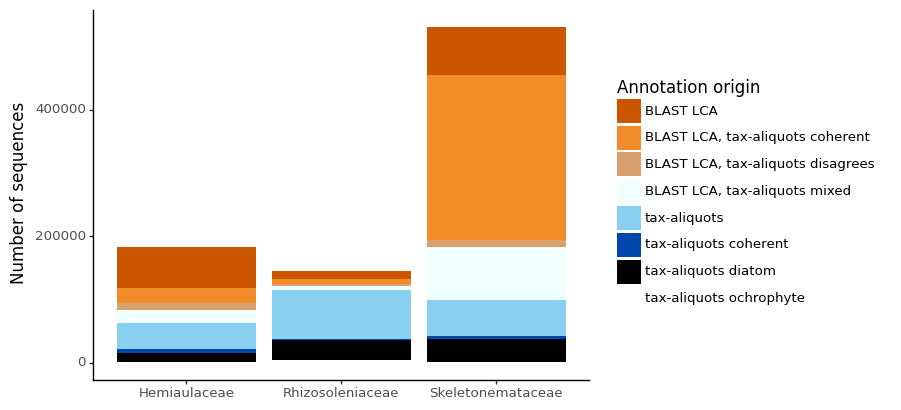

<ggplot: (2932966316794)>

In [40]:
plotnine.ggplot(concat_frame) + plotnine.geom_bar(plotnine.aes(x="Family",y="transcript_name",
                                                                fill="AnnotationType"),stat="identity") + \
    plotnine.xlab("") + \
    plotnine.ylab("Number of sequences") + \
    plotnine.scale_fill_manual(values=["#CC5500","#F28C28","#DAA06D","#F0FFFF","#89CFF0","#0047AB","black","white"],
                               name="Annotation origin")+\
    plotnine.theme_classic(base_size=12)